PyGSLIB
========

bigaus
---------------




In [1]:
#general imports
import matplotlib.pyplot as plt   
import pygslib as gslib                  
import numpy as np 
import pandas as pd


#make the plots inline
%matplotlib inline  

In [2]:
#get the data in gslib format into a pandas Dataframe
mydata= gslib.read_gslib_file('cluster.dat')  

In [3]:
# This is a 2D file, in this GSLIB version we require 3D data and drillhole name or domain code
# so, we are adding constant elevation = 0 and a dummy BHID = 1 
mydata['Zlocation']=0
mydata['bhid']=1

# printing to verify results
print ' \n **** 5 first rows in my datafile \n\n  ', mydata.head(n=5)

 
 **** 5 first rows in my datafile 

      Xlocation  Ylocation  Primary  Secondary  Declustering Weight  Zlocation  \
0       39.5       18.5     0.06       0.22                1.619          0   
1        5.5        1.5     0.06       0.27                1.619          0   
2       38.5        5.5     0.08       0.40                1.416          0   
3       20.5        1.5     0.09       0.39                1.821          0   
4       27.5       14.5     0.09       0.24                1.349          0   

   bhid  
0     1  
1     1  
2     1  
3     1  
4     1  


## Calculate cutof for given deciles (using declustering wight)

In [4]:
#Calculate gausian values for given deciles 
from scipy.stats import norm
Ycuoff = norm.ppf([0.25, 0.5, 0.75])
print Ycuoff


[-0.67448975  0.          0.67448975]


In [5]:
#get transformation table
transin,transout, error = gslib.__dist_transf.ns_ttable(mydata['Primary'],mydata['Declustering Weight'])
print 'there was any error?: ', error!=0

there was any error?:  False


In [6]:
tt=pd.DataFrame({'Ycuoff': Ycuoff})

In [7]:
#get the equivelent value with back transformation 
Zcutoff,error = gslib.__dist_transf.backtr(tt['Ycuoff'],
                                     transin,transout,
                                     ltail=1,utail=1,ltpar=0,utpar=60,
                                     zmin=0,zmax=60,getrank=0)
print 'there was any error?: ', error!=0, error
print 'Z cutoff', Zcutoff

there was any error?:  False 0
Z cutoff [ 0.34000004  1.109976    2.75563465]


## get some experimental variograms

In [8]:
# these are the parameters we need. Note that at difference of GSLIB this dictionary also stores 
# the actual data (ex, X, Y, etc.). 

#important! python is case sensitive 'bhid' is not equal to 'BHID'

cut = mydata['Primary']<Zcutoff[0]
mydata['ind_25'] = cut.astype(float) 
cut = mydata['Primary']<Zcutoff[1]
mydata['ind_50'] = cut.astype(float) 
cut = mydata['Primary']<Zcutoff[2]
mydata['ind_75'] = cut.astype(float) 


parameters = { 
'x'      :  mydata['Xlocation']   , # X coordinates, array('f') with bounds (nd), nd is number of data points
'y'      :  mydata['Ylocation'],    # Y coordinates, array('f') with bounds (nd)
'z'      :  mydata['Zlocation'],    # Z coordinates, array('f') with bounds (nd)
'bhid'   :  mydata['bhid'],         # bhid for downhole variogram, array('i') with bounds (nd)    
'vr'     :  mydata['ind_25']  ,  # Variables, array('f') with bounds (nd,nv), nv is number of variables
'tmin'   : -1.0e21,                 # trimming limits, float
'tmax'   :  1.0e21,                 # trimming limits, float
'nlag'   :  10,                     # number of lags, int
'xlag'   :  2,                      # lag separation distance, float                
'xltol'  :  1,                      # lag tolerance, float
'azm'    : [0],                     # azimuth, array('f') with bounds (ndir)
'atol'   : [22.5],                  # azimuth tolerance, array('f') with bounds (ndir)
'bandwh' : [10000],                 # bandwith h, array('f') with bounds (ndir)
'dip'    : [0],                     # dip, array('f') with bounds (ndir)
'dtol'   : [10],                    # dip tolerance, array('f') with bounds (ndir)
'bandwd' : [10],                    # bandwith d, array('f') with bounds (ndir)
'isill'  : 0,                       # standardize sills? (0=no, 1=yes), int
'sills'  : [100],                   # variance used to std the sills, array('f') with bounds (nv)
'ivtail' : [1],                     # tail var., array('i') with bounds (nvarg), nvarg is number of variograms
'ivhead' : [1],                     # head var., array('i') with bounds (nvarg)
'ivtype' : [1],                     # variogram type, array('i') with bounds (nvarg)
'maxclp' : 50000}                   # maximum number of variogram point cloud to use, input int

'''
Remember this is GSLIB... use this code to define variograms
type 1 = traditional semivariogram
     2 = traditional cross semivariogram
     3 = covariance
     4 = correlogram
     5 = general relative semivariogram
     6 = pairwise relative semivariogram
     7 = semivariogram of logarithms
     8 = semimadogram

'''              

pdis25,pgam25, phm,ptm,phv,ptv,pnump, cldi, cldj, cldg, cldh = gslib.gamv(parameters)

#check the variogram is ok
assert gslib.check_gamv_par(parameters)==1 , 'sorry this parameter file is wrong' 


In [9]:
#Now we are ready to calculate the veriogram

parameters = { 
'x'      :  mydata['Xlocation']   , # X coordinates, array('f') with bounds (nd), nd is number of data points
'y'      :  mydata['Ylocation'],    # Y coordinates, array('f') with bounds (nd)
'z'      :  mydata['Zlocation'],    # Z coordinates, array('f') with bounds (nd)
'bhid'   :  mydata['bhid'],         # bhid for downhole variogram, array('i') with bounds (nd)    
'vr'     :  mydata['ind_50']  ,  # Variables, array('f') with bounds (nd,nv), nv is number of variables
'tmin'   : -1.0e21,                 # trimming limits, float
'tmax'   :  1.0e21,                 # trimming limits, float
'nlag'   :  10,                     # number of lags, int
'xlag'   :  2,                      # lag separation distance, float                
'xltol'  :  1,                      # lag tolerance, float
'azm'    : [0],                     # azimuth, array('f') with bounds (ndir)
'atol'   : [22.5],                  # azimuth tolerance, array('f') with bounds (ndir)
'bandwh' : [10000],                 # bandwith h, array('f') with bounds (ndir)
'dip'    : [0],                     # dip, array('f') with bounds (ndir)
'dtol'   : [10],                    # dip tolerance, array('f') with bounds (ndir)
'bandwd' : [10],                    # bandwith d, array('f') with bounds (ndir)
'isill'  : 0,                       # standardize sills? (0=no, 1=yes), int
'sills'  : [100],                   # variance used to std the sills, array('f') with bounds (nv)
'ivtail' : [1],                     # tail var., array('i') with bounds (nvarg), nvarg is number of variograms
'ivhead' : [1],                     # head var., array('i') with bounds (nvarg)
'ivtype' : [1],                     # variogram type, array('i') with bounds (nvarg)
'maxclp' : 50000}                   # maximum number of variogram point cloud to use, input int

pdis50,pgam50, phm,ptm,phv,ptv,pnump, cldi, cldj, cldg, cldh = gslib.gamv(parameters)

print 'Zcutoff', Zcutoff
#print mydata[['Primary','ind_25', 'ind_50']]

Zcutoff [ 0.34000004  1.109976    2.75563465]


Test bigaus
-----

We are using variogram of logarithms... 


In [10]:
print gslib.__bigaus.bigaus.__doc__

zc,out_j,out_l,out_h,out_ri,out_ci,out_rop,out_p,error = bigaus(c0,it,cc,aa,aa1,aa2,ang1,ang2,ang3,nlag,azm,dip,xlag,zcc,[nst,ncut,ndir])

Wrapper for ``bigaus``.

Parameters
----------
c0 : input rank-1 array('f') with bounds (1)
it : input rank-1 array('i') with bounds (nst)
cc : input rank-1 array('f') with bounds (nst)
aa : input rank-1 array('f') with bounds (nst)
aa1 : input rank-1 array('f') with bounds (nst)
aa2 : input rank-1 array('f') with bounds (nst)
ang1 : input rank-1 array('f') with bounds (nst)
ang2 : input rank-1 array('f') with bounds (nst)
ang3 : input rank-1 array('f') with bounds (nst)
nlag : input int
azm : input rank-1 array('f') with bounds (ndir)
dip : input rank-1 array('f') with bounds (ndir)
xlag : input rank-1 array('f') with bounds (ndir)
zcc : input rank-1 array('f') with bounds (ncut)

Other Parameters
----------------
nst : input int, optional
    Default: len(it)
ncut : input int, optional
    Default: len(zcc)
ndir : input int, optional
    Default: 

In [11]:
parameters ={'zcc' : [ 0.25, 0.5, 0.75],    #threshold cdf values
             'nlag':  20,                        #number lags
             'azm' : [0.0],                        #azm(1), dip(1), lag(1)
             'dip' : [0.],
             'xlag': [1.], 
             'c0'  :  [0.2],         # nugget,  array('f') with bounds (ivarg)  
             'it'  :  [1,1],        # structure type,  array('i') with bounds (ivarg)              
             'cc'  :  [0.4,0.4],    # variance, array('f') with bounds (nvarg*nst[0])
             'aa'  :  [10,10],     # parameter a (or range), array('f') with bounds (nvarg*nst[0])    
             'aa1' :  [5,5],     # parameter a (or range), array('f') with bounds (nvarg*nst[0])    
             'aa2' :  [10,10],     # parameter a (or range), array('f') with bounds (nvarg*nst[0])    
             'ang1':  [0.,0],
             'ang2':  [0.,0],
             'ang3':  [0.,0]}
                      
zc,out_j,out_l,out_h,out_ri,out_ci,out_rop,out_p,error = gslib.__bigaus.bigaus(**parameters) 

"""
result=pd.Panel({'lag numb:':out_j,
                     'number of pairs:':out_l,
                     'lag separation:':out_h,
                     'variogram:':out_ri,
                     'mean of the tail:':out_ci,
                     'variogram standardized:':out_rop})
"""
print 'any error', error!=0


any error False


In [12]:
print 'zc:', zc
print 'p:', out_p

zc: [-0.6744898  0.         0.6744898]
p: [ 0.24999997  0.5         0.75      ]


In [13]:
#nlag,ndir,ncut
vcut=0
vdir=0
np.set_printoptions(precision=3)
print out_ri[:,:,vcut]
#print out_h[:,:,vcut]

[[ 0.   ]
 [ 0.103]
 [ 0.121]
 [ 0.136]
 [ 0.149]
 [ 0.161]
 [ 0.17 ]
 [ 0.177]
 [ 0.183]
 [ 0.186]
 [ 0.188]
 [ 0.188]
 [ 0.188]
 [ 0.188]
 [ 0.188]
 [ 0.188]
 [ 0.188]
 [ 0.188]
 [ 0.188]
 [ 0.188]]


** Compare with standard GSLIB bigaus output **
``` 
********************GSLIB output***********************
Model Indicator Variogram: cutoff =   -0.674 Direction 

                 (vr-vcut=0)
  1    0.000        0.000      1      1.17810      0.00000
  2    1.000        0.103      1      0.53184      0.54856
  3    2.000        0.121      1      0.41848      0.64478
  4    3.000        0.136      1      0.32192      0.72675
  5    4.000        0.149      1      0.23902      0.79712
  6    5.000        0.161      1      0.16845      0.85701
  7    6.000        0.170      1      0.10978      0.90682
  8    7.000        0.177      1      0.06307      0.94646
  9    8.000        0.183      1      0.02872      0.97562
 10    9.000        0.186      1      0.00738      0.99374
 11   10.000        0.188      1      0.00000      1.00000
 12   11.000        0.188      1      0.00000      1.00000
 13   12.000        0.188      1      0.00000      1.00000
 14   13.000        0.188      1      0.00000      1.00000
 15   14.000        0.188      1      0.00000      1.00000
 16   15.000        0.188      1      0.00000      1.00000
 17   16.000        0.188      1      0.00000      1.00000
 18   17.000        0.188      1      0.00000      1.00000
 19   18.000        0.188      1      0.00000      1.00000
 20   19.000        0.188      1      0.00000      1.00000

```

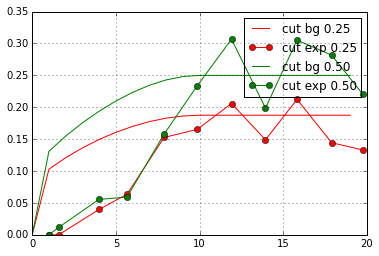

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

#plotting the variogram 1 only
v=0

plt.plot (out_h[:,:,0], out_ri[:,:,0], 'r-', label='cut bg 0.25')
plt.plot (pdis25[0, 0, 1:], pgam25[0, 0, 1:], 'r-o', label='cut exp 0.25')

plt.plot (out_h[:,:,1], out_ri[:,:,1], 'g-', label='cut bg 0.50')
plt.plot (pdis50[0, 0, 1:], pgam50[0, 0, 1:], 'g-o', label='cut exp 0.50')

plt.legend()
plt.grid(True)
plt.show()